Using the latest cached version of the dataset since ag_news couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at C:\Users\weixi\.cache\huggingface\datasets\ag_news\default\0.0.0\eb185aade064a813bc0b7f42de02595523103ca4 (last modified on Fri Jan 23 03:18:17 2026).


Epoch 01: Train Loss=0.4857, Train Acc=0.8165, Test Loss=0.3100, Test Acc=0.8955
Epoch 02: Train Loss=0.2481, Train Acc=0.9138, Test Loss=0.2645, Test Acc=0.9108
Epoch 03: Train Loss=0.1897, Train Acc=0.9352, Test Loss=0.2577, Test Acc=0.9101
Epoch 04: Train Loss=0.1474, Train Acc=0.9493, Test Loss=0.2648, Test Acc=0.9146
Epoch 05: Train Loss=0.1100, Train Acc=0.9627, Test Loss=0.2766, Test Acc=0.9114
Epoch 06: Train Loss=0.0786, Train Acc=0.9733, Test Loss=0.3278, Test Acc=0.9074
Epoch 07: Train Loss=0.0545, Train Acc=0.9818, Test Loss=0.3755, Test Acc=0.9072
Epoch 08: Train Loss=0.0383, Train Acc=0.9870, Test Loss=0.4061, Test Acc=0.9083
Epoch 09: Train Loss=0.0280, Train Acc=0.9908, Test Loss=0.4490, Test Acc=0.9042
Epoch 10: Train Loss=0.0207, Train Acc=0.9937, Test Loss=0.5022, Test Acc=0.9059


Text(0.5, 1.0, 'Loss and Accuracy Curve')

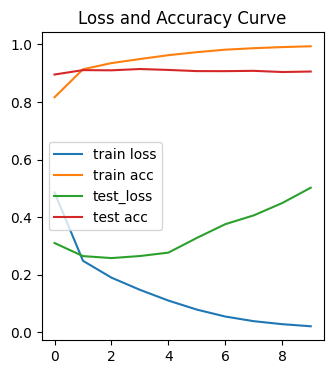

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from datasets import load_dataset
from transformers import AutoTokenizer
import matplotlib.pyplot as plt

#基础配置
device = "cuda" if torch.cuda.is_available() else "cpu"
batch_size = 64
embed_dim = 64
hidden_dim = 128
epochs = 10
lr = 1e-3
max_len = 100
num_classes = 4

#加载配置
dataset = load_dataset("ag_news")
train_data = dataset["train"]
test_data = dataset["test"]

#tokenizer配置
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

#dataset + collate
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.texts = data["text"]
        self.labels = data["label"]

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]
    
def collate_fn(batch):
    texts, labels = zip(*batch)

    encoded = tokenizer(
        list(texts),
        padding=True,
        truncation=True,
        max_length=max_len,
        return_tensors="pt"
    )

    return (
        encoded["input_ids"].to(device),
        torch.tensor(labels).to(device)
    )

#dataloader
train_loader = DataLoader(
    TextDataset(train_data),
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn
)

test_loader = DataLoader(
    TextDataset(test_data),
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn
)

#attention + LSTM分类模型
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.proj = nn.Linear(hidden_dim, 1)
    
    def forward(self, lstm_out):
        #lstm_out:[B, T, H]
        scores = self.proj(lstm_out).squeeze(-1)
        weights = torch.softmax(scores, dim=1)
        context = torch.sum(lstm_out * weights.unsqueeze(-1), dim=1)
        return context, weights
    
class LSTMAttentionClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes):
        super().__init__()
        self.embedding = nn.Embedding(
            vocab_size, embed_dim, padding_idx=tokenizer.pad_token_id)
        self.lstm = nn.LSTM(
            embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.attention = Attention(2 * hidden_dim)
        self.fc = nn.Linear(2 * hidden_dim, num_classes)

    def forward(self, x):
        """
        x: [batch_size, seq_len]
        """
        x = self.embedding(x) #[B, T, E]
        lstm_out, _ = self.lstm(x)

        # # h_n: [num_layers * num_directions, B, H]
        # # 取双向最后一层
        # final_hidden = torch.cat(
        #     (h_n[-1], h_n[-2]), dim=1
        # )

        context, weights = self.attention(lstm_out)
        logits = self.fc(context)

        return logits, weights
    
#初始化
model = LSTMAttentionClassifier(
    vocab_size=tokenizer.vocab_size,
    embed_dim=embed_dim,
    hidden_dim=hidden_dim,
    num_classes=num_classes
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

#训练 + 测试曲线
train_losses, train_accs = [], []
test_losses, test_accs = [], []

for epoch in range(epochs):
    #train
    model.train()
    train_loss, correct, total, total_loss = 0, 0, 0, 0

    for input_ids, labels in train_loader:
        optimizer.zero_grad()

        logits, _ = model(input_ids)
        loss = criterion(logits, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = total_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    #eval
    model.eval()
    total_loss, correct, total, total_loss = 0, 0, 0, 0

    with torch.no_grad():
        for input_ids, labels in test_loader:
            logits, _ = model(input_ids)
            loss = criterion(logits, labels)

            total_loss += loss.item()
            preds = logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        test_loss = total_loss / len(test_loader)
        test_acc = correct / total
        test_losses.append(test_loss)
        test_accs.append(test_acc)

    print(f"Epoch {epoch+1:02d}: "
          f"Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, "
          f"Test Loss={test_loss:.4f}, Test Acc={test_acc:.4f}")
    
plt.figure(figsize=(8,4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="train loss")
plt.plot(train_accs, label="train acc")
plt.plot(test_losses, label="test_loss")
plt.plot(test_accs, label="test acc")
plt.legend()
plt.title("Loss and Accuracy Curve")